#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
#размер графиков
sns.set(rc={"figure.figsize":(12, 6)})
#темная тема для графиков
plt.style.use('dark_background')

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные загружены. В нашем распоряжении примерно 26000 строк. Выполним ресемплирование по одному часу

In [ ]:
data = data.resample('1H').sum()

In [ ]:
#check
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


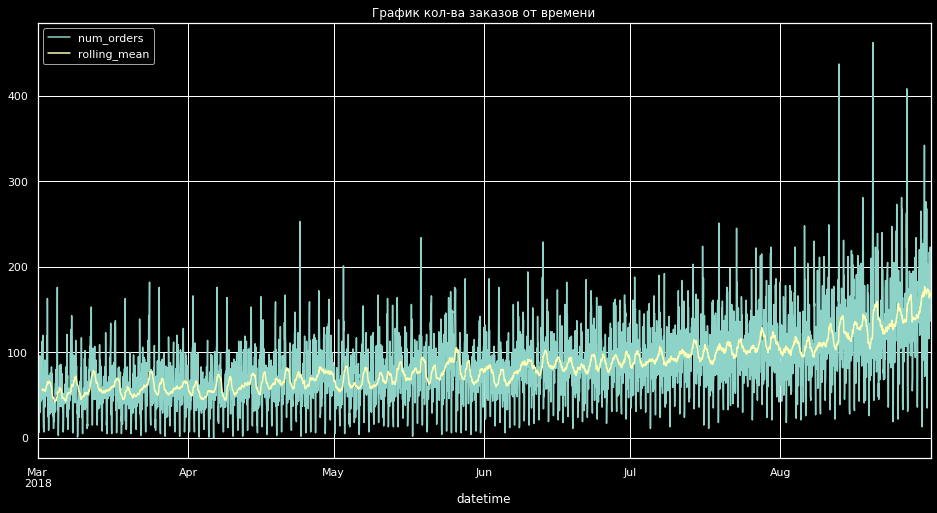

In [ ]:
data2 = data.copy()
data2['rolling_mean'] = data2.rolling(24).mean()
data2.plot(figsize=(16,8))
plt.title('График кол-ва заказов от времени')
plt.show()

**Вывод по разделу:**
Данные загружены, выполнено их ресемплирование по одному часу

## Анализ

Выполним тест Дики-Фуллера для проверки на стационарность

In [ ]:
result = adfuller(data['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза отвергнута – Временной ряд стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


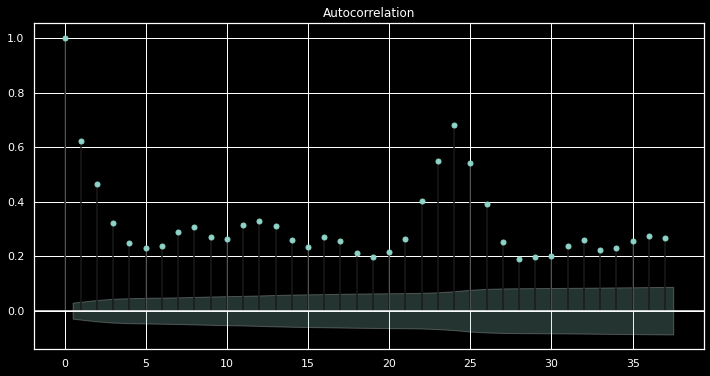

In [ ]:
plot_acf(data)
plt.show()

Оценим тренд и сезонность

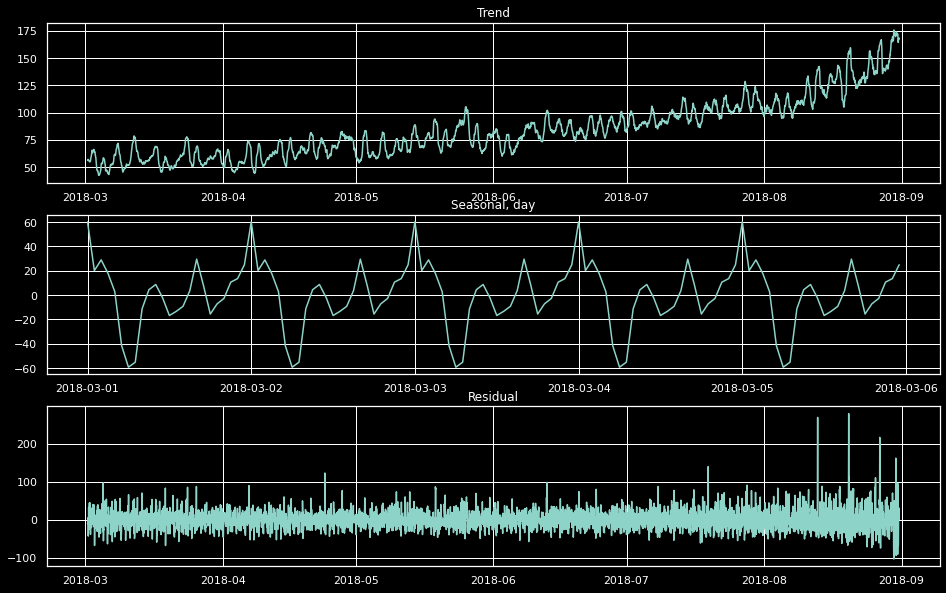

In [ ]:
decomposed = seasonal_decompose(data)

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal['2018-03-01':'2018-03-05'])
axs[1].set_title("Seasonal, day")


axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

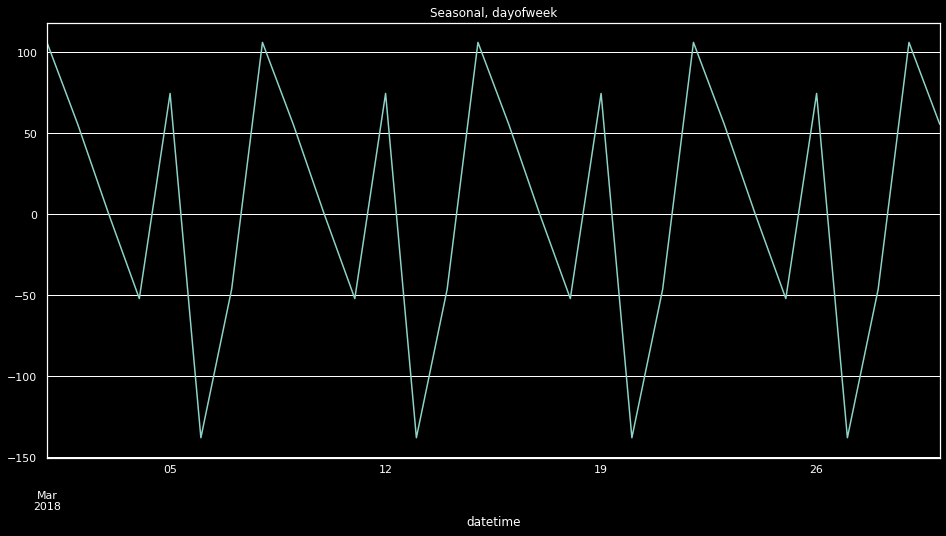

In [ ]:
data3= data.copy()
data3 = data3['2018-03-01':'2018-04-01'].resample('1D').sum()
decomposed2 = seasonal_decompose(data3)
plt.figure(figsize=(16, 8))
decomposed2.seasonal['2018-03-01':'2018-03-30'].plot()
plt.title('Seasonal, dayofweek')
plt.show()

Как мы можем видеть на графике в данных присутствует тренд на увеличение заказов такси (однако, учитвыая что у нас нет данных хотя бы за 2 года возможно это сезонность по годам), сезонности в течение дня и сезонность по дням недели. Учитываю сезонность в течение дня логично создать features  cо значением lag = 24.

## Обучение

Создадим новые признаки

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy(deep=True)
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [ ]:
df = make_features(data, 24, 1)

In [ ]:
#check
df.head()

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0


Разделим df на выборки

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

Создадим data frame для сбора результатов обучения моделей

In [ ]:
model_result = pd.DataFrame(columns=['RMSE'])

In [ ]:
def result(score, model_name, df):
    df.loc[model_name,'RMSE'] = score
    return df

Функция для обучения модели

In [ ]:
tscv = TimeSeriesSplit(n_splits=8)

In [ ]:
def model_work (model, name):
    score = cross_val_score(model, X_train, y_train,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=tscv)
    return result(abs(score).mean(), name, model_result)

### LinearRegression

In [ ]:
model_work(LinearRegression(), 'LinearRegression')

,RMSE
LinearRegression,26.624293


### LightGBM

Подбор гиперпараметров с помощью GridSearchSV

In [ ]:
params_lgbm = {
    "n_estimators" : [10, 50, 100],
    "max_depth": [-1, 3, 5]
              }
lgbm = LGBMRegressor(random_state=46)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, scoring='neg_root_mean_squared_error', cv=tscv)
grid_lgbm.fit(X_train, y_train)
print('Best RMSE: %.2f'%(grid_lgbm.best_score_*(-1)), ' Best Params : ', str(grid_lgbm.best_params_))

Best RMSE: 24.38  Best Params :  {'max_depth': -1, 'n_estimators': 50}


In [ ]:
model_work(LGBMRegressor(random_state=46, **grid_lgbm.best_params_), 'LGBMRegressor')

,RMSE
LinearRegression,26.624293
LGBMRegressor,24.3783


### Catboost

Подбор гиперпараметров с помощью RandomizedSearchCV

In [ ]:
cat = CatBoostRegressor(silent=True, random_state=46)
params_cat = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]}
grid_cat = GridSearchCV(estimator=cat, param_grid = params_cat, scoring='neg_root_mean_squared_error', cv=tscv)
grid_cat.fit(X_train, y_train)
print('Best RMSE: %.2f'%(grid_cat.best_score_*(-1)), ' Best Params : ', str(grid_cat.best_params_))

Best RMSE: 24.40  Best Params :  {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}


In [ ]:
model_work(CatBoostRegressor(silent=True, random_state=46, **grid_cat.best_params_), 'CatBoostRegressor')

,RMSE
LinearRegression,26.624293
LGBMRegressor,24.3783
CatBoostRegressor,24.396778


<b> Вывод по разделу:</b><br>
Для обучения подготовки моделей были сгенерированы новые признаки. Были обучены 3 моедли. Наилучшее значение RMSE показал LGBMRegressor. Протестируем данную модель.

## Тестирование

In [ ]:
lgbm = LGBMRegressor(random_state=46, **grid_lgbm.best_params_)
lgbm.fit(X_train, y_train)
lgbm_predictions = lgbm.predict(X_test)
print("RMSE:", (mse(lgbm_predictions, y_test)**0.5))

RMSE: 41.82136497315326


Визуализируем наши предсказания

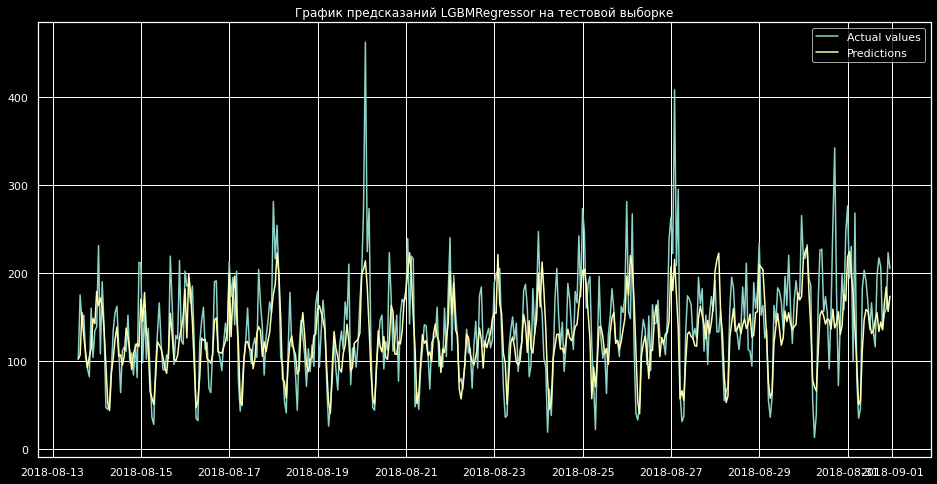

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, lgbm_predictions, label='Predictions')
plt.title('График предсказаний LGBMRegressor на тестовой выборке')
plt.legend()
plt.show()

## Вывод

В ходе проекты выполнены следующие этапы:
- Загружены данные и выполнено их ресемплирование по одному часу.
- Данные проанализированы. Выполнена проверка временного ряда на стационарность, ряд стационарен. Обнаружен тренд на увеличение заказов такси и сезонности в течение дня.
- Подготовлены выборки для обучения моедлей и тестирования. Размер тестовой выборки - 10%. Обучены модели LinearRegression, LightGBM и Catboost с определением оптимальных гиперпараметров. Выполнена оценка моделей с помощью кроссвалидации и метрики RMSE. Наилучший показатель на обучающей выборки был у LightGBM.
- Протестирована моедль LightGBM. Знаечние RMSE 41.8, что удовлетворяет требованиям ТЗ (значение метрики RMSE на тестовой выборке должно быть не больше 48).